# Broad Topic Classification

While some of the research outputs supplied by users could be identified and therefore programmatically classified into the two broad categories of "Life Sciences" and "Earth Sciences", there were far more that could not be identified. In order to make an estimate of the types of projects being completed, it is necessary to attempt to classify these remaining outputs.

This notebook details an attempt to train a Support Vector Machine (SVM) classifier and a Naive Bayes classifier in order to categorise the outputs based on their titles.

In [1]:
%matplotlib inline
import sqlitedict

## Training data

Get a list of journals represented by the identified outputs:

In [2]:
metadata = sqlitedict.SqliteDict('../synth/data/doi_metadata.db')
journal_list = []
for k, v in metadata.items():
    issn = v.get('ISSN', [])
    journal_list += issn
journal_list = list(set(journal_list))

for j in journal_list[:3]:
    print(j)

0165-0009
0003-4541
0930-0708


Scrape the ASJC data from this page: https://service.elsevier.com/app/answers/detail/a_id/15181/supporthub/scopus

In [3]:
from bs4 import BeautifulSoup
import requests

response = requests.get('https://service.elsevier.com/app/answers/detail/a_id/15181/supporthub/scopus')
page = BeautifulSoup(response.content)
table_rows = page.find('table').find_all('tr')[1:]
all_asjc = [tuple([cell.text for cell in row.find_all('td')]) for row in table_rows]
asjc = {x[0]: x[2] for x in all_asjc}

for x in all_asjc[:3]:
    print(x)

for x in list(asjc.items())[:3]:
    print(x)

('1000', 'Multidisciplinary', 'Multidisciplinary')
('1100', 'General Agricultural and Biological Sciences', 'Life Sciences')
('1101', 'Agricultural and Biological Sciences (miscellaneous)', 'Life Sciences')
('1000', 'Multidisciplinary')
('1100', 'Life Sciences')
('1101', 'Life Sciences')


Categorise each journal based on the subjects it's tagged with on CrossRef.

In [4]:
from crossref.restful import Etiquette, Journals
from collections import Counter
import json
import os

# multithreading speeds the download process up
from concurrent.futures import ThreadPoolExecutor
from tqdm.contrib.concurrent import thread_map

etiquette = Etiquette('SYNTH transform', '0.1', 'https://github.com/NaturalHistoryMuseum/synth_transform',
                      'data@nhm.ac.uk')
journal_api = Journals(etiquette=etiquette)

if os.path.exists('journals.json'):
    with open('journals.json', 'r') as f:
        all_issns = json.load(f)
else:
    all_issns = []

    def get_journal(issn):
        journal = journal_api.journal(issn)
        if journal is None:
            return
        subjects = journal.get('subjects', [])
        top_level_subjects = Counter([asjc.get(str(s['ASJC'])) for s in subjects])

        # for each category, make sure there's no overlap between subjects
        if top_level_subjects['Life Sciences'] > 0 and top_level_subjects['Physical Sciences'] == 0:
            all_issns.append((issn, 'life'))
        elif top_level_subjects['Physical Sciences'] > 0 and top_level_subjects['Life Sciences'] == 0:
            all_issns.append((issn, 'earth'))
        elif len(top_level_subjects) > 0 and top_level_subjects['Life Sciences'] == 0 and top_level_subjects['Physical Sciences'] == 0:
            all_issns.append((issn, 'other'))

    with ThreadPoolExecutor(10) as thread_executor:
        thread_map(get_journal, journal_list)
        
    with open('journals.json', 'w') as f:
        json.dump(all_issns, f)
        
print(len([j for j in all_issns if j[1] == 'life']))
print(len([j for j in all_issns if j[1] == 'earth']))
print(len([j for j in all_issns if j[1] == 'other']))

479
177
45


Get a sample of articles from each journal, attempting to ignore irrelevant results such as front/back matter, tables of contents, etc.

Since the "other" category is so small and encompasses a much greater variety of topics, the accuracy of the classifier is unlikely to be acceptable for this category. For the sake of simplicity, this category will be ignored.

In [5]:
import os
import re

all_issns = [j for j in all_issns if j[1] != 'other']

if os.path.exists('titles.json'):
    # load from json file if possible because downloading new results will take quite a while
    with open('titles.json', 'r') as f:
        work_titles = json.load(f)
else:
    work_titles = {
        'earth': [],
        'life': []
    }
    
    ignore = [re.compile(i) for i in 
              ['(front|back) matter',
               'special issue',
               'price\W',
               '(volume|issue) \d']
             ]
    
    def iter_works(issn, add_to):
        for attempt in range(3):
            try:
                works = list(journal_api.works(issn).sample(100))
                break
            except json.decoder.JSONDecodeError:
                works = []
                continue
        for work in works:
            title = work.get('title')
            if title is None or len(title) == 0:
                continue
            title = title[0].lower()
            if len(title.split(' ')) < 5:
                # ignore it if it has fewer than 5 words in the title - these are usually not articles
                continue
            if any([rgx.search(title) is not None for rgx in ignore]):
                continue
            work_titles[add_to].append(title)
        
    
    with ThreadPoolExecutor(10) as thread_executor:
        thread_map(lambda x: iter_works(*x), all_issns)
        
    with open('titles.json', 'w') as f:
        json.dump(work_titles, f)


Transform the titles into data that can be used to train the classifier by:
1. removing punctuation (except hyphens);
2. discarding words that aren't nouns or adjectives;
3. stemming words so that e.g. "geology" and "geological" are both counted as the same word;
4. discarding the most frequent words.

In [6]:
import pandas as pd
from nltk.stem.porter import PorterStemmer
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
stemmer = PorterStemmer()

no_punct_rgx = re.compile(r'[^a-z- ]')
en_em_dash_rgx = re.compile(r'\s-\s')

def get_tokens(txt, add_to):
    txt = no_punct_rgx.sub(' ', txt.lower())
    txt = en_em_dash_rgx.sub(' ', txt)
    doc = nlp(txt)
    tokens = [stemmer.stem(token.text) for token in doc if
              token.pos_ in ['NOUN', 'ADJ'] and len(token.lemma_) > 1]
    add_to.append(tokens)


if os.path.exists('training_data.csv'):
    # again, read from a file if available because this might take a while
    df = pd.read_csv('training_data.csv', index_col=0)
else:
    def process_texts(texts):
        token_lists = []

        with ThreadPoolExecutor(10) as thread_executor:
            thread_map(lambda x: get_tokens(x, token_lists), texts)

        all_tokens = [t for sublist in token_lists for t in set(sublist)]
        most_common = [k for k, v in sorted(Counter(all_tokens).items(), key=lambda x: -x[1])][:20]
        print(most_common)

        output = [' '.join([token for token in doc if token not in most_common]) for doc in token_lists]

        return output


    # transform the data into (title, label) tuples
    data = [(x, k) for k, v in work_titles.items() for x in v]
    df = pd.DataFrame(data, columns=['text', 'label'])
    df.text = process_texts(df.text)
    df = df.where(df != '').dropna(axis=0)
    min_rows = min(df[df.label == 'earth'].shape[0], df[df.label == 'life'].shape[0])
    df = pd.concat([df[df.label == 'earth'].sample(min_rows),
                    df[df.label == 'life'].sample(min_rows)])
    df.to_csv('training_data.csv')
    
print(df.sample(5))

                                                    text  label
3118                                   role tethi region  earth
43523  contribut knowledg australiandicranolaiuschampion   life
29879   low genet variabl south eastern sever bottleneck   life
43706                                                gel   life
19099                                               pick   life


Split the data into a training group and a testing group.

In [7]:
from sklearn.model_selection import train_test_split

if os.path.exists('train_split.csv') and os.path.exists('test_split.csv'):
    training_data = pd.read_csv('train_split.csv', index_col=0)
    test_data = pd.read_csv('test_split.csv', index_col=0)
else:
    training_data, test_data = train_test_split(df, test_size=0.2, stratify=df.label, random_state=123)
    training_data.to_csv('train_split.csv')
    test_data.to_csv('test_split.csv')

## Training the classifier

Create a vectoriser to get a numerical representation of the text.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

if os.path.exists('vectoriser.pkl'):
    with open('vectoriser.pkl', 'rb') as f:
        vectoriser = pickle.load(f)
else:
    vectoriser = TfidfVectorizer(max_df=0.95, min_df=2, max_features=6000)
    vectoriser.fit(training_data.text)
    with open('vectoriser.pkl', 'wb') as f:
        pickle.dump(vectoriser, f)

features = vectoriser.transform(training_data.text)

print(features[0])

  (0, 5610)	0.3345529603556887
  (0, 5038)	0.2967042192386826
  (0, 4931)	0.27332180467587464
  (0, 4604)	0.31698617006567686
  (0, 4504)	0.3874448101162035
  (0, 2710)	0.291649421572918
  (0, 1945)	0.280851235425778
  (0, 1342)	0.42581872911990387
  (0, 264)	0.3598388661328168


Use those features to train a Support Vector Machine (SVM) classifier.

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from datetime import datetime as dt

if os.path.exists('svc.model'):
    with open('svc.model', 'rb') as f:
        svc_classifier = pickle.load(f)
else:
    # enabling probability calculations takes a lot longer, but allows for more specific margins of error
    svc_classifier = SVC(class_weight='balanced', probability=True)
    print('Fitting SVC...')
    start = dt.now()
    svc_classifier.fit(features, training_data.label)
    print(f'Done ({round((dt.now() - start).total_seconds())}s)')
    with open('svc.model', 'wb') as f:
        pickle.dump(svc_classifier, f)

svc_predicted = svc_classifier.predict(vectoriser.transform(test_data.text))
print(f'Accuracy: {round(accuracy_score(test_data.label, svc_predicted) * 100, 2)}%')
print(classification_report(test_data.label, svc_predicted))
print(confusion_matrix(test_data.label, svc_predicted))

Accuracy: 86.51%
              precision    recall  f1-score   support

       earth       0.88      0.84      0.86      3102
        life       0.85      0.89      0.87      3102

    accuracy                           0.87      6204
   macro avg       0.87      0.87      0.87      6204
weighted avg       0.87      0.87      0.87      6204

[[2610  492]
 [ 345 2757]]


## Predictions

Use the trained classifier to estimate the broad category of titles in the database.

First, retrieve the list of research output titles.

In [10]:
from synth.model.analysis import Output
from synth.utils import Config, Context
import yaml
from sqlalchemy.orm import sessionmaker

with open('../config.yml', 'r') as f:
    config = Config(**yaml.safe_load(f))

context = Context(config)
session = sessionmaker(bind=context.target_engine)()

titles = [t[0] for t in session.query(Output.title).filter(Output.title.isnot(None)).all()]

for t in titles[:5]:
    print(t)

Molecular phylogeny within true bugs (Hemiptera: Miridae).
Gene-flow solid frozen - the roles of intrinsic and extrinsic factors on microevolution of Antarctic shelf fishes
Age and rate of speciation in the adaptive radiation of antarctic fishes (Trematominae)
Did glacial advances during the Pleistocene influence differently the demographic histories of benthic and pelagic Antarctic shelf fishes? – Inferences from intraspecific mitochondrial and nuclear DNA sequence diversity
Contribution to the Pupae of the Western Palearctic Tiger Moths (Lepidoptera, Noctuoidea, Arctiidae).


Transform each title into the same format as the training dataset; i.e. lowercase, no punctuation, nouns and adjectives only, etc.

In [11]:
processed_titles = []

with ThreadPoolExecutor(10) as thread_executor:
    thread_map(lambda x: get_tokens(x, processed_titles), titles)

# results are returned as lists of tokens, so these need to be joined back together
processed_titles = [' '.join(t) for t in processed_titles]
    
for t in processed_titles[:5]:
    print(t)


gene flow solid role intrins extrins factor microevolut antarct shelf fish
true bug
contribut pupa western palearct moth noctuoidea
contribut descript pupa western noctuida



Vectorise the titles and predict the category for each.

In [12]:
transformed_titles = vectoriser.transform(processed_titles)
predictions = pd.Series(svc_classifier.predict(transformed_titles), name='Category')

print(predictions.value_counts())

life     6878
earth    2716
Name: Category, dtype: int64


The certainty of each match can also be calculated.

In [13]:
prediction_probabilities = svc_classifier.predict_proba(transformed_titles)

category_probability = pd.concat(
    [pd.Series(titles, name='Title'),
     predictions,
     pd.Series(prediction_probabilities.max(axis=1), name='Probability')], axis=1)

print('EARTH:')
print(category_probability[category_probability.Category=='earth'].sample(10))
print('\n')
print('LIFE:')
print(category_probability[category_probability.Category=='life'].sample(10))

EARTH:
                                                  Title Category  Probability
2819  Asiorrhina, a new Oriental genus of Lygistorrh...    earth     0.940966
4171  A redefinition of Misumenops F.O. Pickard-Camb...    earth     0.565371
3480  DNA extraction from formalin-fixed tissue: new...    earth     0.999315
7012  The Portalón at Cueva Mayor (Sierra de Atapuer...    earth     0.994256
2535  Die Evolution intrauteriner Ernährung bei Vert...    earth     0.989842
288   Tiphotrephes immaculatus sp.n. (Heteroptera: H...    earth     0.942700
7557  Revision of the attaphilous genus Phoxonotus (...    earth     0.891048
5449  The lumbar vertebrae of the Middle Miocene ste...    earth     0.805691
4493  Three times out of Asia Minor: the phylogeogra...    earth     0.600470
7175  Nacre and other shell microstructures in the O...    earth     0.953364


LIFE:
                                                  Title Category  Probability
6829  RECENT OBSERVATIONS ON OPHRYS SPECIES AND H

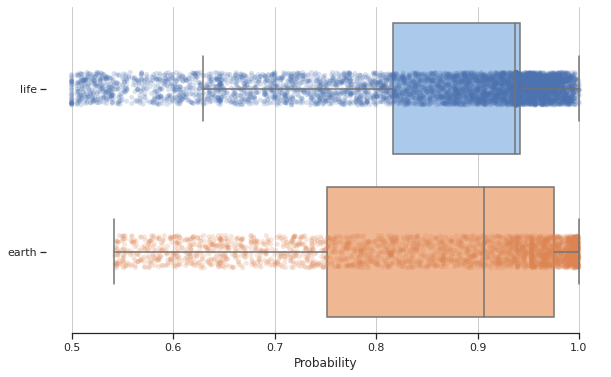

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Probability', y='Category', data=category_probability, palette='pastel', fliersize=0)
sns.stripplot(x='Probability', y='Category', data=category_probability, alpha=0.2, zorder=1)

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

plt.show()